# Performance Measures

In [8]:
# Settings and imports.
%matplotlib inline
from collections import OrderedDict
from math import floor, log
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
import data

sns.set()
sns.set_context('poster')
#sns.set_style('whitegrid')
pd.options.display.float_format = '{:.2f}'.format

## Prepare Data

In [41]:
snapshots = data.load('robomission-2018-03-10/program_snapshots.csv')
edits = snapshots[snapshots.granularity == 'edit']
executions = snapshots[snapshots.granularity == 'execution']
tasks = data.load('robomission-2018-03-10/tasks.csv')
levels = data.load('robomission-2018-03-10/levels.csv')
tasks = tasks.assign(level=tasks.level.apply(
    lambda name: levels[levels.name==name].level.values[0]))


def time_to_thinking(time, time_per_thinking=5):
    return floor(log(time, time_per_thinking)) if time > 0 else 0
    
snapshots['thinking'] = snapshots.time_delta.apply(time_to_thinking)

ts = data.load('robomission-2018-03-10/task_sessions.csv')
ts = ts.drop(['start', 'end'], axis=1)
ts = ts[ts.time_spent > 0]
ts.time_spent = ts.time_spent.clip_upper(60 * 60)
ts = ts.join(tasks.level, on='task')
ts.head()

,student,task,solved,time_spent,level
id,,,,,
39,917,26,False,62,1
28,584,41,True,63,4
13,29,8,True,17,2
1,5,25,True,14,1
2,29,25,True,12,1


## Level to time, edits, runs, thinking, actions

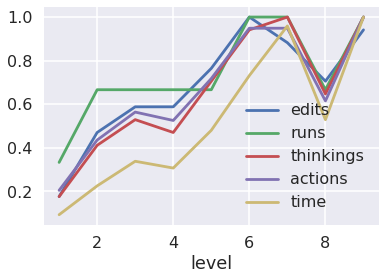

In [53]:
edit_count = edits.groupby('task_session').program.count()
run_count = executions.groupby('task_session').program.count()
thinking_count = snapshots.groupby('task_session').thinking.sum()

ts = ts.assign(
    edits=edit_count,
    runs=run_count,
    thinkings=thinking_count,
    actions=(edit_count + run_count + thinking_count),
    time=ts.time_spent,
    #time=ts.time_spent.apply(np.log),
).fillna(0)
perfs = ts.groupby('level').median()
normperfs = perfs / perfs.max()
normperfs[['edits', 'runs', 'thinkings', 'actions', 'time']].plot()

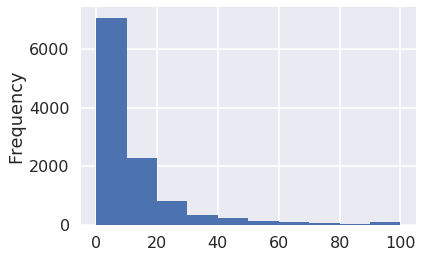

In [56]:
thinking_count.clip_upper(100).plot.hist()

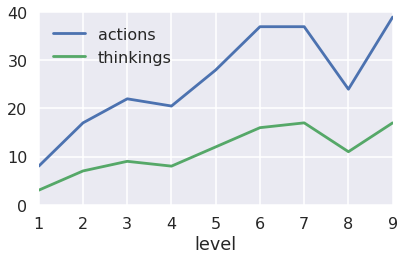

In [77]:
# Suggest that it should  be enough to consider thinkings
# errors = pd.DataFrame(
#     {'down': gr.median() - gr.quantile(0.25),
#      'up': gr.quantile(0.75) - gr.median()}).values.T

ax = perfs[['actions', 'thinkings']].plot()
ax.set_xlim(1, 9)
ax.set_xticks(list(range(1, 10)))
ax.set_ylim(0, 40)
#ax2 = perfs.time.plot(secondary_y=True, style='g')
plt.tight_layout()
plt.savefig('../img/actions-thinkings.pdf')

In [68]:
perfs.reset_index()

,level,student,task,solved,time_spent,edits,runs,thinkings,actions,time
0,1,9046.50,44.00,True,24.00,3.00,1.00,3.00,8.00,24.00
1,2,9053.00,12.00,True,58.00,8.00,2.00,7.00,17.00,58.00
2,3,9054.00,21.00,True,87.00,10.00,2.00,9.00,22.00,87.00
3,4,9051.00,41.00,True,79.00,10.00,2.00,8.00,20.50,79.00
4,5,9055.50,55.00,True,123.50,13.00,2.00,12.00,28.00,123.50
5,6,9056.00,59.00,True,188.00,17.00,3.00,16.00,37.00,188.00
6,7,9056.00,64.00,True,246.50,15.00,3.00,17.00,37.00,246.50
7,8,9255.00,43.00,True,136.00,12.00,2.00,11.00,24.00,136.00
8,9,9179.00,40.00,False,257.00,16.00,3.00,17.00,39.00,257.00


(0, 100)

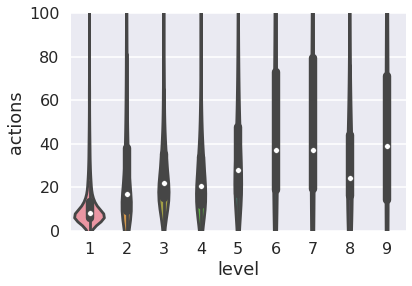

In [71]:
ax = sns.violinplot(data=ts, x='level', y='actions')
ax.set_xlabel('level')
ax.set_ylabel('actions')
ax.set_ylim(bottom=0, top=100)